In [1]:
import numpy as np
import pandas as pd

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBClassifier
import optuna


In [2]:
abundance = pd.read_csv("../../results/data/prepared/processed_abundance.csv")
clinical = pd.read_csv("../../results/data/prepared/clinical.csv")
groups = pd.read_csv("../../results/data/prepared/groups.csv")

abundance = abundance.pivot(index="sample", columns="glycan", values="value")
abundance = pd.DataFrame(np.log2(abundance.values), columns=abundance.columns, index=abundance.index)
clinical = clinical.drop(["sex", "age"], axis=1)
clinical = clinical.set_index("sample")
groups = groups.set_index("sample")
data = pd.merge(abundance, clinical, left_index=True, right_index=True, how="inner")
data = pd.merge(data, groups, left_index=True, right_index=True, how="inner")
data = data[data["group"] != "QC"]
data["group"] = data["group"] == "C"

In [3]:
clinical_features = clinical.columns.tolist()
glycan_features = abundance.columns.tolist()

In [4]:
train_data, test_data = train_test_split(data, test_size=128, random_state=42, stratify=data["group"], shuffle=True)

In [5]:
X_train = train_data.drop("group", axis=1)
y_train = train_data["group"]
X_test = test_data.drop("group", axis=1)
y_test = test_data["group"]

In [6]:
X_train.head()

,H3N3,H3N3F1,H3N4,H3N4F1,H3N5,H3N5F1,H4N2,H4N3,H4N3F1,H4N3F1S1,...,AST,ALT,GGT,ALB,TBIL,TP,AFP,HCV,CEA,CA199
sample,,,,,,,,,,,,,,,,,,,,,
S123,12.126891,11.797564,11.188617,15.992716,12.049130,13.325982,9.530232,12.296704,11.684790,8.530232,...,0,11,0,42.82,16.9,67.7,0.00,0.0,0.00,0.00
S549,11.953019,11.901987,11.459164,15.417039,11.663211,13.153128,9.874411,12.007467,11.942351,12.653387,...,25,23,424,34.38,44.9,59.9,0.00,0.0,0.00,0.00
S626,11.829985,11.687135,10.294023,15.006981,11.386611,13.257160,10.294023,11.859289,11.422261,12.404590,...,21,15,21,49.80,11.4,75.8,3.47,0.0,1.99,14.96
S494,10.952821,11.795057,12.204758,16.395196,13.424326,14.955106,9.244854,11.210018,11.668416,12.166124,...,42,29,63,29.70,32.5,62.3,21.24,0.0,0.00,21.63
S377,10.415901,12.225450,10.415901,15.459247,11.415901,13.515596,10.415901,12.414026,11.720350,12.469854,...,14,9,0,42.60,12.7,74.7,2.91,0.0,0.00,0.00


In [7]:
xgb = XGBClassifier(n_estimators=1000)
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
svm = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))

models = {
    "XGBoost": xgb,
    "Random Forest": rf,
    "Logistic Regression": lr,
    "SVM": svm
}

datasets = {
    "Clinical": X_train[clinical_features],
    "Glycans": X_train[glycan_features],
    "All": X_train
}

for dataset_name, X in datasets.items():
    print(f"Dataset: {dataset_name}")
    for name, model in models.items():
        accs = cross_val_score(model, X, y_train, cv=10, scoring="accuracy")
        aucs = cross_val_score(model, X, y_train, cv=10, scoring="roc_auc")
        print(f"{name} ACC: {accs.mean():.4f} +/- {accs.std():.4f}")
        print(f"{name} AUC: {aucs.mean():.4f} +/- {aucs.std():.4f}")
    print()

Dataset: Clinical
XGBoost ACC: 0.8679 +/- 0.0449
XGBoost AUC: 0.9347 +/- 0.0276
Random Forest ACC: 0.8833 +/- 0.0389
Random Forest AUC: 0.9398 +/- 0.0291
Logistic Regression ACC: 0.7481 +/- 0.0346
Logistic Regression AUC: 0.8218 +/- 0.0338
SVM ACC: 0.7910 +/- 0.0380
SVM AUC: 0.8644 +/- 0.0287

Dataset: Glycans
XGBoost ACC: 0.7566 +/- 0.0663
XGBoost AUC: 0.8412 +/- 0.0530
Random Forest ACC: 0.7823 +/- 0.0646
Random Forest AUC: 0.8461 +/- 0.0609
Logistic Regression ACC: 0.7463 +/- 0.0840
Logistic Regression AUC: 0.8184 +/- 0.0766
SVM ACC: 0.7791 +/- 0.0584
SVM AUC: 0.8410 +/- 0.0651

Dataset: All
XGBoost ACC: 0.8509 +/- 0.0470
XGBoost AUC: 0.9231 +/- 0.0395
Random Forest ACC: 0.8457 +/- 0.0452
Random Forest AUC: 0.9162 +/- 0.0409
Logistic Regression ACC: 0.7841 +/- 0.0549
Logistic Regression AUC: 0.8457 +/- 0.0688
SVM ACC: 0.8132 +/- 0.0481
SVM AUC: 0.8873 +/- 0.0461



In [9]:
def xgb_objective(trial):
    params = {
        "objective": "binary:logistic",
        "n_estimators": 100,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1)
    }
    model = XGBClassifier(**params)
    accs = cross_val_score(model, X_train[clinical_features], y_train, cv=10, scoring="accuracy")
    return accs.mean()

study = optuna.create_study(direction="maximize", study_name="XGBoost")
study.optimize(xgb_objective, n_trials=100)

[I 2024-05-09 15:47:17,167] A new study created in memory with name: XGBoost
[I 2024-05-09 15:47:17,633] Trial 0 finished with value: 0.6077732320280538 and parameters: {'learning_rate': 0.0012718941509855398, 'gamma': 0.43548712049859206, 'reg_alpha': 0.0265715648937007, 'reg_lambda': 0.06028909241946655, 'max_depth': 3, 'min_child_weight': 10, 'colsample_bytree': 0.5443449342468486}. Best is trial 0 with value: 0.6077732320280538.
[I 2024-05-09 15:47:18,714] Trial 1 finished with value: 0.8285797779076564 and parameters: {'learning_rate': 0.0038380480618583554, 'gamma': 0.22589725707147568, 'reg_alpha': 0.008900909530522071, 'reg_lambda': 0.06210823831078107, 'max_depth': 12, 'min_child_weight': 2, 'colsample_bytree': 0.8115403543111951}. Best is trial 1 with value: 0.8285797779076564.
[I 2024-05-09 15:47:19,145] Trial 2 finished with value: 0.8474576271186439 and parameters: {'learning_rate': 0.09755723471877427, 'gamma': 0.778230497823675, 'reg_alpha': 0.4124878288784908, 'reg_lamb

In [10]:
best_xgb_params = study.best_params
best_xgb_params["n_estimators"] = 1000
best_xgb = XGBClassifier(**best_xgb_params)

In [11]:
print(best_xgb_params)

{'learning_rate': 0.0440041393596575, 'gamma': 0.1973855387809742, 'reg_alpha': 0.006678360201501156, 'reg_lambda': 0.003734478252188153, 'max_depth': 11, 'min_child_weight': 3, 'colsample_bytree': 0.6018498743658866, 'n_estimators': 1000}


In [12]:
best_xgb_accs = cross_val_score(best_xgb, X_train[clinical_features], y_train, cv=10, scoring="accuracy")
best_xgb_aucs = cross_val_score(best_xgb, X_train[clinical_features], y_train, cv=10, scoring="roc_auc")

print(f"XGBoost ACC: {best_xgb_accs.mean():.4f} +/- {best_xgb_accs.std():.4f}")
print(f"XGBoost AUC: {best_xgb_aucs.mean():.4f} +/- {best_xgb_aucs.std():.4f}")

XGBoost ACC: 0.8680 +/- 0.0358
XGBoost AUC: 0.9343 +/- 0.0276


Best performance of XGBoost didn't exceed Random Forest.
So Random Forest will be used in the fusion model.

In [14]:
def rf_objective(trial):
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=trial.suggest_int("max_depth", 3, 12),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        max_features=trial.suggest_float("max_features", 0.1, 1),
        random_state=42,
    )
    accs = cross_val_score(rf, X_train[clinical_features], y_train, cv=10, scoring="accuracy")
    return accs.mean()

study = optuna.create_study(direction="maximize", study_name="Random Forest")
study.optimize(rf_objective, n_trials=100)

[I 2024-05-09 15:54:33,861] A new study created in memory with name: Random Forest
[I 2024-05-09 15:54:34,882] Trial 0 finished with value: 0.8474284044418467 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.5929504681838523}. Best is trial 0 with value: 0.8474284044418467.
[I 2024-05-09 15:54:35,877] Trial 1 finished with value: 0.8320864991233197 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.777653442584287}. Best is trial 0 with value: 0.8474284044418467.
[I 2024-05-09 15:54:37,050] Trial 2 finished with value: 0.8491525423728813 and parameters: {'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 0.9677755691088714}. Best is trial 2 with value: 0.8491525423728813.
[I 2024-05-09 15:54:38,140] Trial 3 finished with value: 0.8507890122735242 and parameters: {'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.7624012606096227}.

In [15]:
best_rf = RandomForestClassifier(
    n_estimators=1000,
    **study.best_params,
    random_state=42
)

best_rf_accs = cross_val_score(best_rf, X_train[clinical_features], y_train, cv=10, scoring="accuracy")
best_rf_aucs = cross_val_score(best_rf, X_train[clinical_features], y_train, cv=10, scoring="roc_auc")

print(f"Random Forest ACC: {best_rf_accs.mean():.4f} +/- {best_rf_accs.std():.4f}")
print(f"Random Forest AUC: {best_rf_aucs.mean():.4f} +/- {best_rf_aucs.std():.4f}")

Random Forest ACC: 0.8730 +/- 0.0442
Random Forest AUC: 0.9303 +/- 0.0348


The Random Forest model didn't perform better with after fine-tuning.
So the default parameters will be used.

In [15]:
def svm_objective(trial):
    svm = SVC(
        C=trial.suggest_float("C", 1e-3, 1e3, log=True),
        gamma=trial.suggest_float("gamma", 1e-3, 1e3, log=True),
        random_state=42,
    )
    model = make_pipeline(StandardScaler(), svm)
    accs = cross_val_score(model, X_train[glycan_features], y_train, cv=10, scoring="accuracy")
    return accs.mean()

study = optuna.create_study(direction="maximize", study_name="SVM")
study.optimize(svm_objective, n_trials=100)

[I 2024-05-09 20:41:57,428] A new study created in memory with name: SVM
[I 2024-05-09 20:41:57,632] Trial 0 finished with value: 0.5513734658094682 and parameters: {'C': 185.0850304727159, 'gamma': 48.281463402394316}. Best is trial 0 with value: 0.5513734658094682.
[I 2024-05-09 20:41:57,793] Trial 1 finished with value: 0.7721215663354764 and parameters: {'C': 0.6235951615529255, 'gamma': 0.011283946156312426}. Best is trial 1 with value: 0.7721215663354764.
[I 2024-05-09 20:41:57,963] Trial 2 finished with value: 0.5513734658094682 and parameters: {'C': 0.12764817245605029, 'gamma': 0.05168568154778785}. Best is trial 1 with value: 0.7721215663354764.
[I 2024-05-09 20:41:58,110] Trial 3 finished with value: 0.5513734658094682 and parameters: {'C': 0.028222360949190114, 'gamma': 0.015182566484726621}. Best is trial 1 with value: 0.7721215663354764.
[I 2024-05-09 20:41:58,283] Trial 4 finished with value: 0.5513734658094682 and parameters: {'C': 0.00205851229597421, 'gamma': 3.492754

In [17]:
study.best_params

{'C': 4.82641306722861, 'gamma': 0.009233891634025245}

In [27]:
best_svm = make_pipeline(StandardScaler(), SVC(C=5, gamma=0.01, probability=True, random_state=42))

best_svm_accs = cross_val_score(best_svm, X_train[glycan_features], y_train, cv=10, scoring="accuracy")
best_svm_aucs = cross_val_score(best_svm, X_train[glycan_features], y_train, cv=10, scoring="roc_auc")

print(f"SVM ACC: {best_svm_accs.mean():.4f} +/- {best_svm_accs.std():.4f}")
print(f"SVM AUC: {best_svm_aucs.mean():.4f} +/- {best_svm_aucs.std():.4f}")

SVM ACC: 0.7841 +/- 0.0556
SVM AUC: 0.8378 +/- 0.0648


In [10]:
def svm_objective(trial):
    svm = SVC(
        C=trial.suggest_float("C", 1e-3, 1e3, log=True),
        gamma=trial.suggest_float("gamma", 1e-3, 1e3, log=True),
        random_state=42,
    )
    model = make_pipeline(PowerTransformer(method="box-cox"), StandardScaler(), svm)
    accs = cross_val_score(model, X_train[glycan_features], y_train, cv=10, scoring="accuracy")
    return accs.mean()

study = optuna.create_study(direction="maximize", study_name="SVM with Box-Cox")
study.optimize(svm_objective, n_trials=100)

[I 2024-05-10 11:03:31,306] A new study created in memory with name: SVM with Box-Cox
[I 2024-05-10 11:03:32,457] Trial 0 finished with value: 0.5513734658094682 and parameters: {'C': 0.008362889031060122, 'gamma': 0.007850078152306613}. Best is trial 0 with value: 0.5513734658094682.
[I 2024-05-10 11:03:33,507] Trial 1 finished with value: 0.5513734658094682 and parameters: {'C': 0.021554369368069037, 'gamma': 0.006500741140160344}. Best is trial 0 with value: 0.5513734658094682.
[I 2024-05-10 11:03:34,583] Trial 2 finished with value: 0.5513734658094682 and parameters: {'C': 10.72061597859089, 'gamma': 0.7355554021291971}. Best is trial 0 with value: 0.5513734658094682.
[I 2024-05-10 11:03:35,653] Trial 3 finished with value: 0.5513734658094682 and parameters: {'C': 453.93019395313485, 'gamma': 0.9211131259629239}. Best is trial 0 with value: 0.5513734658094682.
[I 2024-05-10 11:03:36,780] Trial 4 finished with value: 0.7311221507890122 and parameters: {'C': 391.00311147415437, 'gamm

Adding Box-Cox transformation didn't boost the performance.

In [26]:
param_grid = {
    "fs__k": [5, 10, 20, 30, 40, 50],
    "fs__score_func": [f_classif, mutual_info_classif]
}

svm_with_fs = Pipeline([
    ("box-cox", PowerTransformer(method="box-cox")),
    ("fs", SelectKBest()),
    ("scaler", StandardScaler()),
    ("svm", SVC(C=4.8, gamma=0.009, probability=True, random_state=42))
])

svm_with_fs_cv = GridSearchCV(svm_with_fs, param_grid, cv=10, scoring="accuracy")
svm_with_fs_cv.fit(X_train[glycan_features], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('box-cox',
                                        PowerTransformer(method='box-cox')),
                                       ('fs', SelectKBest()),
                                       ('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(C=4.8, gamma=0.009,
                                            probability=True,
                                            random_state=42))]),
             param_grid={'fs__k': [5, 10, 20, 30, 40, 50],
                         'fs__score_func': [<function f_classif at 0x161f8e3b0>,
                                            <function mutual_info_classif at 0x161f8cca0>]},
             scoring='accuracy')

In [28]:
svm_with_fs_cv.best_score_

0.789187609585038

In [29]:
svm_with_fs_cv.best_params_

{'fs__k': 50,
 'fs__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

Feature selection didn't boost the performance of SVM.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels


class FusionModel(BaseEstimator, TransformerMixin, ClassifierMixin):

    clinical_features = clinical.columns.tolist()
    glycan_features = abundance.columns.tolist()

    def __init__(self, clinical_model, glycan_model):
        self.clinical_model = clinical_model
        self.glycan_model = glycan_model
        self.final_model = LogisticRegression(random_state=42)

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.clinical_model.fit(X[self.clinical_features], y)
        self.glycan_model.fit(X[self.glycan_features], y)
        proba_clinical = self.clinical_model.predict_proba(X[self.clinical_features])[:, 1]
        proba_glycan = self.glycan_model.predict_proba(X[self.glycan_features])[:, 1]
        X_fusion = np.vstack([proba_clinical, proba_glycan]).T
        self.final_model.fit(X_fusion, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        proba_clinical = self.clinical_model.predict_proba(X[self.clinical_features])[:, 1]
        proba_glycan = self.glycan_model.predict_proba(X[self.glycan_features])[:, 1]
        X_fusion = np.vstack([proba_clinical, proba_glycan]).T
        return self.final_model.predict(X_fusion)
    
    def predict_proba(self, X):
        proba_clinical = self.clinical_model.predict_proba(X[self.clinical_features])[:, 1]
        proba_glycan = self.glycan_model.predict_proba(X[self.glycan_features])[:, 1]
        X_fusion = np.vstack([proba_clinical, proba_glycan]).T
        return self.final_model.predict_proba(X_fusion)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

best_rf = RandomForestClassifier(n_estimators=1000, random_state=42)
best_svm = make_pipeline(StandardScaler(), SVC(C=5, gamma=0.01, probability=True, random_state=42))
fusion_model = FusionModel(clinical_model=best_rf, glycan_model=best_svm)

fusion_accs = cross_val_score(fusion_model, X_train, y_train, cv=10, scoring="accuracy")
fusion_aucs = cross_val_score(fusion_model, X_train, y_train, cv=10, scoring="roc_auc")

print(f"Fusion ACC: {fusion_accs.mean():.4f} +/- {fusion_accs.std():.4f}")
print(f"Fusion AUC: {fusion_aucs.mean():.4f} +/- {fusion_aucs.std():.4f}")

Fusion ACC: 0.8935 +/- 0.0459
Fusion AUC: 0.9455 +/- 0.0341


In [33]:
from sklearn.metrics import classification_report

fusion_model.fit(X_train, y_train)
y_pred = fusion_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.89      0.91        71
        True       0.87      0.93      0.90        57

    accuracy                           0.91       128
   macro avg       0.90      0.91      0.91       128
weighted avg       0.91      0.91      0.91       128



In [34]:
from sklearn.metrics import roc_auc_score

y_proba = fusion_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_proba)

0.9597232517914505

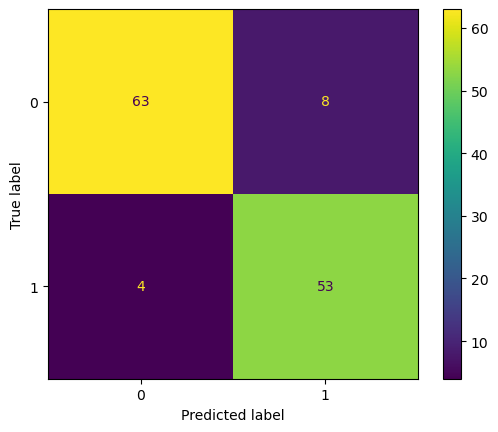

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()